84533.71461985681
85617.6369044226


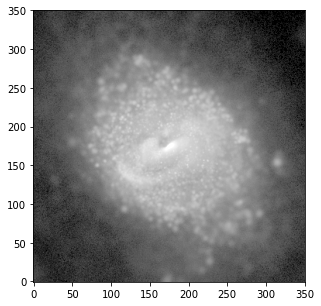

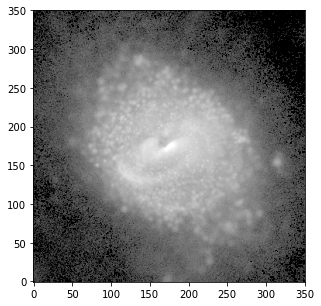

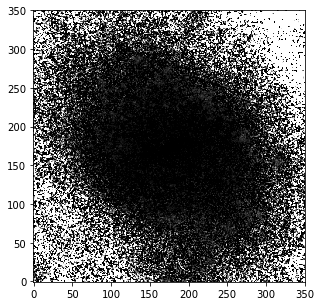

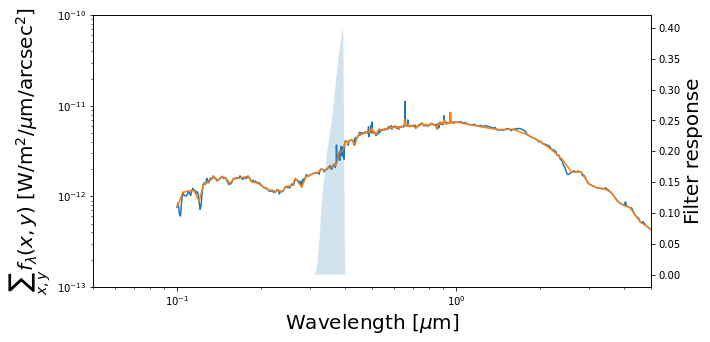

In [22]:
import os,sys,string,time
import numpy as np
from astropy.io import fits

def apply_filter(data_cube,wavelengths,filter_data,redshift=0.0,airmass=0.,overwrite=0):

    # useful constants / quantities
    speed_of_light = 2.998e8 # [m/s]
    speed_of_light = speed_of_light*1e10 # [Angstrom/s]
    
    # convert data cube from [W/m2/micron/arcsec2] to [Jy*Hz/Angstrom/arcsec2]
    data_cube=data_cube*1e22

    # wavelengths of datacube [microns] (expand by redshift factor)
    wl=wavelengths*1e4*(1+redshift) # [Angstrom]

    # filter data
    filter_wl = filter_data[:,0]
    filter_res = filter_data[:,1]

    # filter response interpolated onto image wavelength grid
    filter_res = np.interp(xp=filter_wl,x=wl,fp=filter_res,left=0,right=0) # unitless

    # filter-specific pivot wavelength squared [Angstrom2]
    wl_pivot2 = np.trapz(filter_res*wl,wl)/np.trapz(filter_res/wl,wl)
    
    # now the mean photon rate density in the filter [Jy*Hz/Angstrom/arcsec2]
    f_wl = np.trapz((wl*filter_res).reshape(-1,1,1)*data_cube,wl,axis=0)/np.trapz(wl*filter_res,wl)

    # multiplying by wl_pivot2/speed_of_light gives [Jy/arcsec2]
    # convert to maggies/arcsec2 (w/ AB zeropoint) using 1 maggy ~ 3631 Jy
    # apply (1+z)**-5 redshift degradation to wavelength specific intensities
    f_mgys = f_wl*wl_pivot2/speed_of_light/3631.*(1+redshift)**-5 # [maggies/arcsec2]

    # convert to mag/arcsec2 surface brightness for numerical ease
    with np.errstate(divide='ignore'):
        f_sb = -2.5*np.log10(f_mgys) # [mag/arcsec2] AB system
        f_sb[f_sb==np.inf]=99.

    return f_sb

if __name__=='__main__':
    
    snap=51
    sub=4
    cam='v0'
    
    sim_path = '/home/bottrell/projects/def-simardl/bottrell/Simulations/IllustrisTNG'
    filter_path = f'{sim_path}/Scripts/Photometry/Filters'
    skirt_path = f'{sim_path}/Scripts/SKIRT'
    data_path = f'{sim_path}/TNG50-1/postprocessing/SKIRT'
    
    file_names = [
        f'{data_path}/{snap:03}/FineGrid_{snap:03}-{sub}_{cam}_total.fits',
        f'{data_path}/{snap:03}/shalo_{snap:03}-{sub}_{cam}_total.fits',
                  ]
    
    images = []
    for file_name in file_names:
        
        if not os.access(file_name,0):
            print(f'Data cube file: {file_name} not found. Skipping...')

        else:
            # read IFU cube header and data
            with fits.open(file_name,mode='readonly') as hdul:
                # IFU header
                header = hdul[0].header
                # image spectral flux density in [W/m2/micron/arcsec2]
                data_cube = hdul[0].data

            if 'Fine' in file_name:
                wavelengths = np.loadtxt(f'{skirt_path}/FineWavelength_Grid.dat',skiprows=1).astype(float)
            else:
                wavelengths = np.loadtxt(f'{skirt_path}/Wavelength_Grid.dat',skiprows=1).astype(float)

            filter_data = np.loadtxt(f'{filter_path}/CFHT_MegaCam.u.dat')
            #filter_data = np.loadtxt(f'{filter_path}/Subaru_HSC.g.dat')
            #filter_data = np.loadtxt(f'{filter_path}/UKIRT_UKIDSS.J.dat')

            image = apply_filter(data_cube,wavelengths,filter_data)
            images.append(image)
            print(np.sum(10**(0.4*(22.5-image))))
            
            import matplotlib.pyplot as plt
            fig,ax=plt.subplots(figsize=(5,5))
            ax.imshow(image,origin='lower',cmap='Greys',vmin=18,vmax=28)

    fig,ax=plt.subplots(figsize=(5,5))
    
    residual = 10**(0.4*(22.5-images[0])) / 10**(0.4*(22.5-images[1]))
            
    ax.imshow(residual,origin='lower',cmap='Greys_r',vmin=1,vmax=2)

    import matplotlib.pyplot as plt
    
    fig,ax=plt.subplots(figsize=(10,5))
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax2 = ax.twinx()
    ax2.fill_between(filter_data[:,0]/1e4,filter_data[:,1],zorder=-1,alpha=0.2)
    ax.set_xlabel('Wavelength [$\mu$m]',fontsize=20)
    ax2.set_ylabel('Filter response',fontsize=20)
    ax.set_ylabel('$\sum_{x,y} f_{\lambda}(x,y)$ [W/m$^2$/$\mu$m/arcsec$^2$]',fontsize=20)


    for file_name in file_names:

        with fits.open(file_name,mode='readonly') as hdul:
            # IFU header
            header = hdul[0].header
            # image spectral flux density in [W/m2/micron/arcsec2]
            data_cube = hdul[0].data
            
        if 'Fine' in file_name:
            wavelengths = np.loadtxt(f'{skirt_path}/FineWavelength_Grid.dat',skiprows=1).astype(float)
        else:
            wavelengths = np.loadtxt(f'{skirt_path}/Wavelength_Grid.dat',skiprows=1).astype(float)
                
        ax.plot(wavelengths,wavelengths*np.sum(data_cube,axis=(1,2)))
    ax.set_ylim(1e-13,1e-10)
    ax.set_xlim(0.05,5)
    
    

        


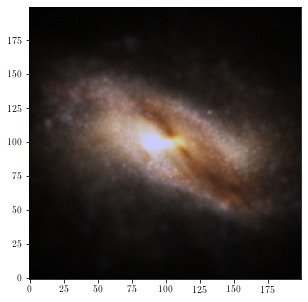

In [414]:
import os,sys,string,time
import numpy as np
from astropy.io import fits

def apply_filter(data_cube,wavelengths,filter_data,redshift=0.0,airmass=0.,overwrite=0):

    # useful constants / quantities
    speed_of_light = 2.998e8 # [m/s]
    speed_of_light = speed_of_light*1e10 # [Angstrom/s]
    
    # convert data cube from [W/m2/micron/arcsec2] to [Jy*Hz/Angstrom/arcsec2]
    data_cube=data_cube*1e22

    # wavelengths of datacube [microns] (expand by redshift factor)
    wl=wavelengths*1e4*(1+redshift) # [Angstrom]

    # filter data
    filter_wl = filter_data[:,0]
    filter_res = filter_data[:,1]

    # filter response interpolated onto image wavelength grid
    filter_res = np.interp(xp=filter_wl,x=wl,fp=filter_res,left=0,right=0) # unitless

    # filter-specific pivot wavelength squared [Angstrom2]
    wl_pivot2 = np.trapz(filter_res*wl,wl)/np.trapz(filter_res/wl,wl)
    
    # now the mean photon rate density in the filter [Jy*Hz/Angstrom/arcsec2]
    f_wl = np.trapz((wl*filter_res).reshape(-1,1,1)*data_cube,wl,axis=0)/np.trapz(wl*filter_res,wl)

    # multiplying by wl_pivot2/speed_of_light gives [Jy/arcsec2]
    # convert to maggies/arcsec2 (w/ AB zeropoint) using 1 maggy ~ 3631 Jy
    # apply (1+z)**-5 redshift degradation to wavelength specific intensities
    f_mgys = f_wl*wl_pivot2/speed_of_light/3631.*(1+redshift)**-5 # [maggies/arcsec2]

    # convert to mag/arcsec2 surface brightness for numerical ease
    with np.errstate(divide='ignore'):
        f_sb = -2.5*np.log10(f_mgys) # [mag/arcsec2] AB system
        f_sb[f_sb==np.inf]=99.

    return f_sb

def make_bottrell_rgb(rgb,stretch=99.9,q=5,scale_r=0.8,scale_g=0.8,scale_b=1.):
    '''Convert images in rgb format (x,y,images).'''
    # assume images are in mag/arcsec2
    rgb = 10**(0.4*(22.5-rgb))
    rgb_scaled = np.tanh(rgb/np.percentile(rgb,stretch)*q)
    rgb_scaled[...,0]*=scale_r
    rgb_scaled[...,1]*=scale_g
    rgb_scaled[...,2]*=scale_b
    return rgb_scaled

if __name__=='__main__':
    
    snap=51
    sub=4
    cam='v2'
    
    sim_path = '/home/bottrell/projects/def-simardl/bottrell/Simulations/IllustrisTNG'
    filter_path = f'{sim_path}/Scripts/Photometry'
    skirt_path = f'{sim_path}/Scripts/SKIRT'
    data_path = f'{sim_path}/TNG50-1/postprocessing/SKIRT'
    
    file_name = f'{data_path}/{snap:03}/shalo_{snap:03}-{sub}_{cam}_total.fits'
    filters = ['Subaru_HSC.i','Subaru_HSC.r','Subaru_HSC.g']

    if not os.access(file_name,0):
        print(f'Data cube file: {file_name} not found. Skipping...')
    else:
        # read IFU cube header and data
        with fits.open(file_name,mode='readonly') as hdul:
            # IFU header
            header = hdul[0].header
            # image spectral flux density in [W/m2/micron/arcsec2]
            data_cube = hdul[0].data
        wavelengths = np.loadtxt(f'{skirt_path}/TMP/wavelength.dat',skiprows=1).astype(float)
        rgb = np.empty((3,data_cube.shape[1],data_cube.shape[2]))
        for i,filter_name in enumerate(filters):
            filter_data = np.loadtxt(f'{filter_path}/{filter_name}.dat')
            rgb[i] = apply_filter(data_cube,wavelengths,filter_data)
            
        # for plotting
        rgb = rgb.transpose((1,2,0))
        
        import matplotlib.pyplot as plt
        fig,ax = plt.subplots(figsize=(5,5))

        rgb_scaled = make_bottrell_rgb(rgb)

        ax.imshow(rgb_scaled[75:275,75:275,:], origin='lower', interpolation=None)

In [37]:
help(make_lupton_rgb)

Help on function make_lupton_rgb in module astropy.visualization.lupton_rgb:

make_lupton_rgb(image_r, image_g, image_b, minimum=0, stretch=5, Q=8, filename=None)
    Return a Red/Green/Blue color image from up to 3 images using an asinh stretch.
    The input images can be int or float, and in any range or bit-depth.
    
    For a more detailed look at the use of this method, see the document
    :ref:`astropy-visualization-rgb`.
    
    Parameters
    ----------
    
    image_r : `~numpy.ndarray`
        Image to map to red.
    image_g : `~numpy.ndarray`
        Image to map to green.
    image_b : `~numpy.ndarray`
        Image to map to blue.
    minimum : float
        Intensity that should be mapped to black (a scalar or array for R, G, B).
    stretch : float
        The linear stretch of the image.
    Q : float
        The asinh softening parameter.
    filename: str
        Write the resulting RGB image to a file (file type determined
        from extension).
    
    Ret

In [412]:
def cbplot(nrows=1,ncols=1,sharex=False,sharey=False,panelsize_x=5,panelsize_y=5):
    '''My plotting style.'''
    import matplotlib.pyplot as plt
    from matplotlib import rc
    rc('font',**{'family':'serif'})
    rc('text', usetex=True)
    fig,axarr = plt.subplots(nrows,ncols,figsize=(ncols*panelsize_x,nrows*panelsize_y),sharey=sharey,sharex=sharex)
    for ax in np.asarray([axarr]).flat:
        ax.minorticks_on()
        ax.tick_params(axis='both',which='major',direction='in',length=10,width=3,labelsize=18,right=1,top=1)
        ax.tick_params(axis='both',which='minor',direction='in',length=5,width=2,right=1,top=1)
        ax.tick_params(axis='both',which='major',pad=10)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(3)
    return fig,axarr



In [17]:
import os,sys,string,time
import numpy as np
from astropy.io import fits

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.gridspec import GridSpec
rc('font',**{'family':'serif','size':20})
rc('text', usetex=True)
import gc

def apply_filter(data_cube,wavelengths,filter_data,redshift=0.0,airmass=0.,overwrite=0):

    # useful constants / quantities
    speed_of_light = 2.998e8 # [m/s]
    speed_of_light = speed_of_light*1e10 # [Angstrom/s]
    
    # convert data cube from [W/m2/micron/arcsec2] to [Jy*Hz/Angstrom/arcsec2]
    data_cube=data_cube*1e22

    # wavelengths of datacube [microns] (expand by redshift factor)
    wl=wavelengths*1e4*(1+redshift) # [Angstrom]

    # filter data
    filter_wl = filter_data[:,0]
    filter_res = filter_data[:,1]

    # filter response interpolated onto image wavelength grid
    filter_res = np.interp(xp=filter_wl,x=wl,fp=filter_res,left=0,right=0) # unitless

    # filter-specific pivot wavelength squared [Angstrom2]
    wl_pivot2 = np.trapz(filter_res*wl,wl)/np.trapz(filter_res/wl,wl)
    
    # now the mean photon rate density in the filter [Jy*Hz/Angstrom/arcsec2]
    f_wl = np.trapz((wl*filter_res).reshape(-1,1,1)*data_cube,wl,axis=0)/np.trapz(wl*filter_res,wl)

    # multiplying by wl_pivot2/speed_of_light gives [Jy/arcsec2]
    # convert to maggies/arcsec2 (w/ AB zeropoint) using 1 maggy ~ 3631 Jy
    # apply (1+z)**-5 redshift degradation to wavelength specific intensities
    f_mgys = f_wl*wl_pivot2/speed_of_light/3631.*(1+redshift)**-5 # [maggies/arcsec2]

    # convert to mag/arcsec2 surface brightness for numerical ease
    with np.errstate(divide='ignore'):
        f_sb = -2.5*np.log10(f_mgys) # [mag/arcsec2] AB system
        f_sb[f_sb==np.inf]=99.

    return f_sb

def make_bottrell_rgb(rgb,stretch=99.9,q=5,scale_r=0.8,scale_g=0.8,scale_b=1.):
    '''Convert images in rgb format (x,y,images).'''
    # assume images are in mag/arcsec2
    rgb = 10**(0.4*(22.5-rgb))
    rgb_scaled = np.tanh(rgb/np.percentile(rgb,stretch)*q)
    rgb_scaled[...,0]*=scale_r
    rgb_scaled[...,1]*=scale_g
    rgb_scaled[...,2]*=scale_b
    return rgb_scaled


def format_axis(ax):
    for spine in ['top','bottom','left','right']:
        ax.spines[spine].set_linewidth(3)
    ax.tick_params(axis='both',which='major',direction='in',length=10,width=3,labelsize=18,right=1,top=1)
    ax.tick_params(axis='both',which='minor',direction='in',length=5,width=2,right=1,top=1)
    ax.tick_params(axis='both',which='major',pad=10)
    ax.minorticks_on()

def make_grid():

    fig = plt.figure(figsize=(16,8))

    gs = GridSpec(2, 4, figure=fig, wspace=0.05, hspace=0.05)
    ax1 = fig.add_subplot(gs[0:1,0:1])
    ax2 = fig.add_subplot(gs[0:1,1:2])
    ax3 = fig.add_subplot(gs[0:1,2:3])
    ax4 = fig.add_subplot(gs[0:1,3:4])
    ax5 = fig.add_subplot(gs[1:2,:])
    ax5_2 = ax5.twinx()

    for ax in [ax1,ax2,ax3,ax4,ax5,ax5_2]:
        format_axis(ax)
    for ax in [ax1,ax2,ax3,ax4]:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    ax5.set_xlabel('Wavelength, $\lambda$ (\AA)')
    ax5.set_ylabel('$f_{\lambda}$ (W m$^{-2}$ $\mu$m$^{-1}$ arcsec$^{-2}$)')
    ax5.tick_params(axis='y',which='major',right=0)
    ax5.tick_params(axis='y',which='minor',right=0)
    ax5_2.set_ylabel('Transmission (Instr+Atm)',rotation=270,labelpad=25)
    ax5_2.set_ylim(0,1)
    
    return fig,[ax1,ax2,ax3,ax4,ax5,ax5_2]

def main(snap,sub,redshift=0.0,image_idx=0,filters=['Subaru_HSC.i','Subaru_HSC.r','Subaru_HSC.g']):
    
    sim_path = '/home/bottrell/projects/def-simardl/bottrell/Simulations/IllustrisTNG'
    filter_path = f'{sim_path}/Scripts/Photometry'
    skirt_path = f'{sim_path}/Scripts/SKIRT'
    data_path = f'{sim_path}/TNG50-1/postprocessing/SKIRT'
    
    fig,axarr = make_grid()
    
    for cam,ax in zip(['v0','v1','v2','v3'],axarr[:4]):
        file_name = f'{data_path}/{snap:03}/shalo_{snap:03}-{sub}_{cam}_total.fits'
        if not os.access(file_name,0):
            print(f'Data cube file: {file_name} not found. Skipping...')
        else:
            # read IFU cube header and data
            with fits.open(file_name,mode='readonly') as hdul:
                # IFU header
                header = hdul[0].header
                # image spectral flux density in [W/m2/micron/arcsec2]
                data_cube = hdul[0].data
            wavelengths = np.loadtxt(f'{skirt_path}/TMP/wavelength.dat',skiprows=1).astype(float)
            rgb = np.empty((3,data_cube.shape[1],data_cube.shape[2]))
            for i,filter_name in enumerate(filters):
                filter_data = np.loadtxt(f'{filter_path}/{filter_name}.dat')
                rgb[i] = apply_filter(data_cube,wavelengths,filter_data,redshift=redshift)
        # for plotting
        rgb = rgb.transpose((1,2,0))
        rgb_scaled = make_bottrell_rgb(rgb,scale_r=0.8,scale_g=0.8,scale_b=1.)
        ax.imshow(rgb_scaled[75:275,75:275,:], origin='lower', interpolation='None',aspect='auto')
    
#         if cam=='v0':
        spectrum = np.sum(data_cube,axis=(1,2))/(1+redshift)
        axarr[4].plot(wavelengths*1e4*(1+redshift),np.log10(spectrum),c='royalblue',lw=2)

    for filter_name in ['CFHT_MegaCam.u','Subaru_HSC.g','Subaru_HSC.r',
                        'Subaru_HSC.i','Subaru_HSC.z','Subaru_HSC.Y']:
        filter_data = np.loadtxt(f'{filter_path}/{filter_name}.dat')
        if filter_name in ['Subaru_HSC.g','Subaru_HSC.r','Subaru_HSC.i']:
            axarr[5].fill_between(filter_data[:,0],filter_data[:,1],zorder=-1,alpha=0.2,lw=4,edgecolor='black')
        else:
            axarr[5].fill_between(filter_data[:,0],filter_data[:,1],zorder=-1,alpha=0.2,lw=0)
        
    axarr[4].set_xlim(1000,11000)
    axarr[4].set_ylim(-12,-10)
    
    text = [f'TNG50-1 SnapNum: {snap}, SubfindID: {sub}\n',
            f'``Observed" at z={redshift:.1f}']
    
    axarr[4].text(0.025,0.925,''.join(text),transform=axarr[4].transAxes,ha='left',va='top')
    
    outname=f'{filter_path}/test_{image_idx:03d}.png'
    fig.savefig(outname, dpi=1080)
    plt.close()
    

if __name__=='__main__':
    
    snap,sub = 51,4
#     redshifts = np.linspace(0.0,1.5,31)
    redshift = 0.0
    image_idx = 0
#     for image_idx,redshift in enumerate(redshifts):
    gc.collect()
    main(snap,sub,redshift=redshift,image_idx=image_idx)
    



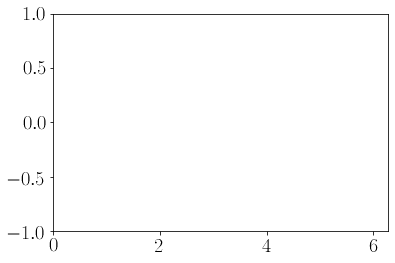

In [521]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], 'ro')

def init():
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-1, 1)
    return ln,

def update(frame):
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True)
plt.show()

In [21]:
import os,sys,string,time
import numpy as np
from astropy.io import fits
import illustris_python as il

def apply_filter(data_cube,wavelengths,filter_data,redshift=0.0,airmass=0.,overwrite=0):

    # useful constants / quantities
    speed_of_light = 2.998e8 # [m/s]
    speed_of_light = speed_of_light*1e10 # [Angstrom/s]
    
    # convert data cube from [W/m2/micron/arcsec2] to [Jy*Hz/Angstrom/arcsec2]
    data_cube=data_cube*1e22

    # wavelengths of datacube [microns] (expand by redshift factor)
    wl=wavelengths*1e4*(1+redshift) # [Angstrom]

    # filter data
    filter_wl = filter_data[:,0]
    filter_res = filter_data[:,1]

    # filter response interpolated onto image wavelength grid
    filter_res = np.interp(xp=filter_wl,x=wl,fp=filter_res,left=0,right=0) # unitless

    # filter-specific pivot wavelength squared [Angstrom2]
    wl_pivot2 = np.trapz(filter_res*wl,wl)/np.trapz(filter_res/wl,wl)
    
    # now the mean photon rate density in the filter [Jy*Hz/Angstrom/arcsec2]
    f_wl = np.trapz((wl*filter_res).reshape(-1,1,1)*data_cube,wl,axis=0)/np.trapz(wl*filter_res,wl)

    # multiplying by wl_pivot2/speed_of_light gives [Jy/arcsec2]
    # convert to maggies/arcsec2 (w/ AB zeropoint) using 1 maggy ~ 3631 Jy
    # apply (1+z)**-5 redshift degradation to wavelength specific intensities
    f_mgys = f_wl*wl_pivot2/speed_of_light/3631.*(1+redshift)**-5 # [maggies/arcsec2]

    # convert to mag/arcsec2 surface brightness for numerical ease
    with np.errstate(divide='ignore'):
        f_sb = -2.5*np.log10(f_mgys) # [mag/arcsec2] AB system
        f_sb[f_sb==np.inf]=99.

    return f_sb

def photometry(snap,sub,cam,sim_tag='TNG50-1',
               filters=['CFHT_MegaCam.u','CFHT_MegaCam.r',
                        'Subaru_HSC.g','Subaru_HSC.r','Subaru_HSC.i','Subaru_HSC.z','Subaru_HSC.Y',
                        'UKIRT_UKIDSS.J','UKIRT_UKIDSS.H','UKIRT_UKIDSS.K',
                        'Spitzer_IRAC.I1','Spitzer_IRAC.I2','Spitzer_IRAC.I3','Spitzer_IRAC.I4']):
    
    sim_path = '/home/bottrell/projects/def-simardl/bottrell/Simulations/IllustrisTNG'
    filter_path = f'{sim_path}/Scripts/Photometry/Filters'
    skirt_path = f'{sim_path}/Scripts/SKIRT'
    data_path = f'{sim_path}/{sim_tag}/postprocessing/SKIRT'
    il_path = f'/scratch/bottrell/Simulations/{sim_tag}/output/'
    
    out_path = f'{sim_path}/{sim_tag}/postprocessing/Photometry/{snap:03}'
    if not os.access(out_path,0):
        os.system(f'mkdir -p {out_path}')
        
    photo_name = f'{out_path}/shalo_{snap:03}-{sub}_{cam}_photo.fits'
    
    redshift = il.groupcat.loadHeader(il_path,snap)['Redshift']

    file_name = f'{data_path}/{snap:03}/shalo_{snap:03}-{sub}_{cam}_total.fits'

    if not os.access(file_name,0):
        print(f'Data cube file: {file_name} not found. Skipping...')
        return
    # read IFU cube header and data
    with fits.open(file_name,mode='readonly') as hdul:
        # IFU header
        header = hdul[0].header
        # image spectral flux density in [W/m2/micron/arcsec2]
        data_cube = hdul[0].data
    
    wavelengths = np.loadtxt(f'{skirt_path}/Wavelength_Grid.dat',skiprows=1).astype(float)
    
    hdul = fits.HDUList()
    for i,filter_name in enumerate(filters):
        filter_data = np.loadtxt(f'{filter_path}/{filter_name}.dat')
        if not (filter_data[-1,0])<=(wavelengths[-1]*1e4*(1+redshift)):
            continue
        image = apply_filter(data_cube,wavelengths,filter_data,redshift=redshift)
        hdu = fits.ImageHDU(image.astype('float32'),name=filter_name)
        hdr = hdu.header
        hdr['SIMTAG'] = (sim_tag,'Simulation name')
        hdr['SNAPNUM'] = (snap,'Simulation snapshot')
        hdr['SUBHALO'] = (sub,'Subhalo ID')
        hdr['ORIGIN'] = ('SKIRT 8 Simulation','Image origin')
        hdr['REDSHIFT'] = (float(f'{redshift:.4f}'),'Redshift')
        hdr['FILTER'] = (filter_name,'Filter name')
        hdr['BUNIT'] = ('AB mag/arcsec2','Image units')
        hdr['CRPIX1'] = (header['CRPIX1'], 'X-axis coordinate system reference pixel')
        hdr['CRVAL1'] = (header['CRVAL1'], 'Coordinate system value at X-axis reference pix')
        hdr['CDELT1'] = (header['CDELT1'], 'Coordinate increment along X-axis')
        hdr['CTYPE1'] = (header['CTYPE1'], 'Physical units of the X-axis increment')
        hdr['CRPIX2'] = (header['CRPIX2'], 'Y-axis coordinate system reference pixel')
        hdr['CRVAL2'] = (header['CRVAL2'], 'Coordinate system value at Y-axis reference pix')
        hdr['CDELT2'] = (header['CDELT2'], 'Coordinate increment along Y-axis')
        hdr['CTYPE2'] = (header['CTYPE2'], 'Physical units of the Y-axis increment')
        hdul.append(hdu)
        
    hdul.writeto(photo_name,overwrite=True)      

if __name__=='__main__':
    
    snap=51
    sub=4
    cam='v3'
    photometry(snap,sub,cam)
    
    


Filename: /home/bottrell/projects/def-simardl/bottrell/Simulations/IllustrisTNG/TNG50-1/postprocessing/Photometry/051/shalo_051-121129_v0_photo.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  CFHT_MEGACAM.U    1 PrimaryHDU      22   (134, 134)   float32   
  1  CFHT_MEGACAM.R    1 ImageHDU        23   (134, 134)   float32   
  2  SUBARU_HSC.G    1 ImageHDU        23   (134, 134)   float32   
  3  SUBARU_HSC.R    1 ImageHDU        23   (134, 134)   float32   
  4  SUBARU_HSC.I    1 ImageHDU        23   (134, 134)   float32   
  5  SUBARU_HSC.Z    1 ImageHDU        23   (134, 134)   float32   
  6  SUBARU_HSC.Y    1 ImageHDU        23   (134, 134)   float32   
  7  UKIRT_UKIDSS.J    1 ImageHDU        23   (134, 134)   float32   
  8  UKIRT_UKIDSS.H    1 ImageHDU        23   (134, 134)   float32   
  9  UKIRT_UKIDSS.K    1 ImageHDU        23   (134, 134)   float32   
 10  SPITZER_IRAC.I1    1 ImageHDU        23   (134, 134)   float32   
 11  SPITZER_IRAC.I2    1 Im

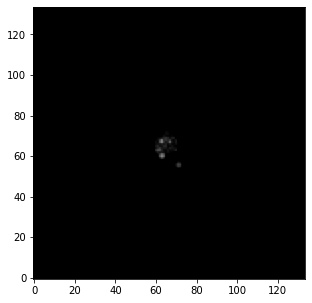

In [3]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np

file_name = '/home/bottrell/projects/def-simardl/bottrell/Simulations/IllustrisTNG/TNG50-1/postprocessing/Photometry/051/shalo_051-121129_v0_photo.fits'

fig,ax = plt.subplots(figsize=(5,5))

with fits.open(file_name,mode='readonly') as hdul:
    print(hdul.info())
    hdu = hdul['CFHT_MEGACAM.U']
    ax.imshow(hdu.data,origin='lower',vmin=18,vmax=28,cmap='Greys')
    print(hdu.header)

In [1]:
import os,sys,string,time,glob
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','size':20})
rc('text', usetex=True)


def make_bottrell_rgb(rgb,stretch=99.9,q=5,scale_r=0.8,scale_g=0.8,scale_b=1.):
    '''Convert images in rgb format (x,y,images).'''
    # assume images are in mag/arcsec2
    rgb = 10**(0.4*(22.5-rgb))
    rgb_scaled = np.tanh(rgb/np.percentile(rgb,stretch)*q)
    rgb_scaled[...,0]*=scale_r
    rgb_scaled[...,1]*=scale_g
    rgb_scaled[...,2]*=scale_b
    return rgb_scaled

if __name__=='__main__':
    
    sim_tag='TNG50-1'
    snap=67
    sub=603409
    
    for cam in ['v0','v1','v2','v3']:
    
        sim_path = '/lustre/work/connor.bottrell/Simulations'
        phot_path = f'{sim_path}/IllustrisTNG/{sim_tag}/postprocessing/Photometry/{snap:03}'

        file_name = f'{phot_path}/shalo_{snap:03}-{sub}_{cam}_photo.fits'
        filters = ['Subaru_HSC.z','Subaru_HSC.i','Subaru_HSC.r']

        if not os.access(file_name,0):
            continue

        # read IFU cube header and data
        with fits.open(file_name,mode='readonly') as hdul:
            # IFU header
            header = hdul[0].header
            npix = header['NAXIS1']
            rgb = np.empty((3,npix,npix))
            for i,filter_name in enumerate(filters):
                rgb[i]=hdul[filter_name].data

        # for plotting
        rgb = rgb.transpose((1,2,0))

        import matplotlib.pyplot as plt
        fig,ax = plt.subplots(figsize=(5,5))

        rgb_scaled = make_bottrell_rgb(rgb,stretch=99.9,q=1,scale_r=0.85,scale_g=0.85,scale_b=1)

        ax.imshow(rgb_scaled, origin='lower', interpolation=None)

['/lustre/work/connor.bottrell/Simulations/IllustrisTNG/TNG50-1/postprocessing/Photometry/067/shalo_067-104_v0_photo.fits', '/lustre/work/connor.bottrell/Simulations/IllustrisTNG/TNG50-1/postprocessing/Photometry/067/shalo_067-104_v1_photo.fits', '/lustre/work/connor.bottrell/Simulations/IllustrisTNG/TNG50-1/postprocessing/Photometry/067/shalo_067-104_v2_photo.fits', '/lustre/work/connor.bottrell/Simulations/IllustrisTNG/TNG50-1/postprocessing/Photometry/067/shalo_067-104_v3_photo.fits', '/lustre/work/connor.bottrell/Simulations/IllustrisTNG/TNG50-1/postprocessing/Photometry/067/shalo_067-105136_v0_photo.fits', '/lustre/work/connor.bottrell/Simulations/IllustrisTNG/TNG50-1/postprocessing/Photometry/067/shalo_067-105136_v1_photo.fits', '/lustre/work/connor.bottrell/Simulations/IllustrisTNG/TNG50-1/postprocessing/Photometry/067/shalo_067-105136_v2_photo.fits', '/lustre/work/connor.bottrell/Simulations/IllustrisTNG/TNG50-1/postprocessing/Photometry/067/shalo_067-105136_v3_photo.fits', '/l

/lustre/work/connor.bottrell/Simulations/IllustrisTNG/TNG50-1/postprocessing/Photometry/067/shalo_067-131719_v0_photo.fits
/lustre/work/connor.bottrell/Simulations/IllustrisTNG/TNG50-1/postprocessing/Photometry/067/shalo_067-131719_v0_photo.fits
/lustre/work/connor.bottrell/Simulations/IllustrisTNG/TNG50-1/postprocessing/Photometry/067/shalo_067-131719_v0_photo.fits
/lustre/work/connor.bottrell/Simulations/IllustrisTNG/TNG50-1/postprocessing/Photometry/067/shalo_067-131719_v0_photo.fits


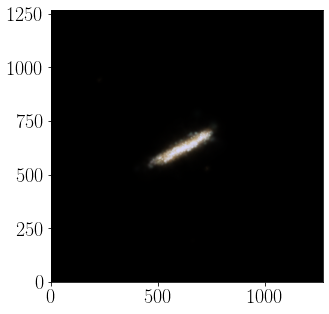

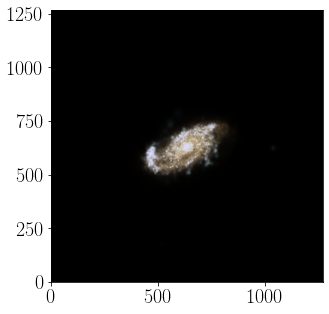

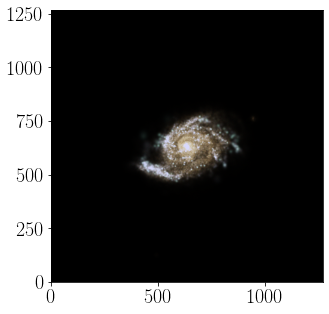

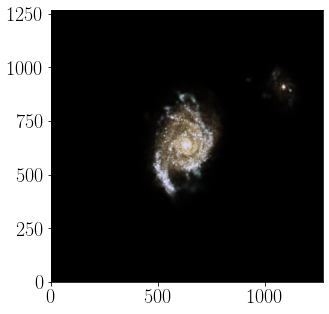

In [62]:
import os,sys,string,time,glob
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','size':20})
rc('text', usetex=True)


def make_bottrell_rgb(rgb,stretch=99.9,q=5,scale_r=0.8,scale_g=0.8,scale_b=1.):
    '''Convert images in rgb format (x,y,images).'''
    # assume images are in mag/arcsec2
    rgb = 10**(0.4*(22.5-rgb))
    rgb_scaled = np.tanh(rgb/np.percentile(rgb,stretch)*q)
    rgb_scaled[...,0]*=scale_r
    rgb_scaled[...,1]*=scale_g
    rgb_scaled[...,2]*=scale_b
    return rgb_scaled

if __name__=='__main__':
    
    sim_tag='TNG50-1'
    snap=67
    sub_idx=50

    
    filters = ['Subaru_HSC.z','Subaru_HSC.i','Subaru_HSC.r']
    
    sim_path = '/lustre/work/connor.bottrell/Simulations'
    phot_path = f'{sim_path}/IllustrisTNG/{sim_tag}/postprocessing/Photometry/{snap:03}'

    file_names = glob.glob(f'{phot_path}/shalo_{snap:03}-*_v0_photo.fits')
    file_names = list(sorted(file_names))
    
    file_name_base = file_names[sub_idx]
    
    for cam in ['v0','v1','v2','v3']:
        
        print(file_name_base)

        file_name = file_name_base.replace('v0',cam)
        
        if not os.access(file_name,0):
            continue

        # read IFU cube header and data
        with fits.open(file_name,mode='readonly') as hdul:
            # IFU header
            header = hdul[0].header
            npix = header['NAXIS1']
            rgb = np.empty((3,npix,npix))
            for i,filter_name in enumerate(filters):
                rgb[i]=hdul[filter_name].data

        # for plotting
        rgb = rgb.transpose((1,2,0))

        import matplotlib.pyplot as plt
        fig,ax = plt.subplots(figsize=(5,5))

        rgb_scaled = make_bottrell_rgb(rgb,stretch=99.9,q=2,scale_r=0.85,scale_g=0.85,scale_b=1)

        ax.imshow(rgb_scaled, origin='lower', interpolation=None)

7.428571428571429